In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.19.0
TensorFlow Decision Forests v1.12.0


In [9]:
#train_file_path = "D:\Downloads D Drive\kaggle project 2_housing price prediction\train.csv"
dataset_df = pd.read_csv(r"train.csv")
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [10]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipython-input-3430012634.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


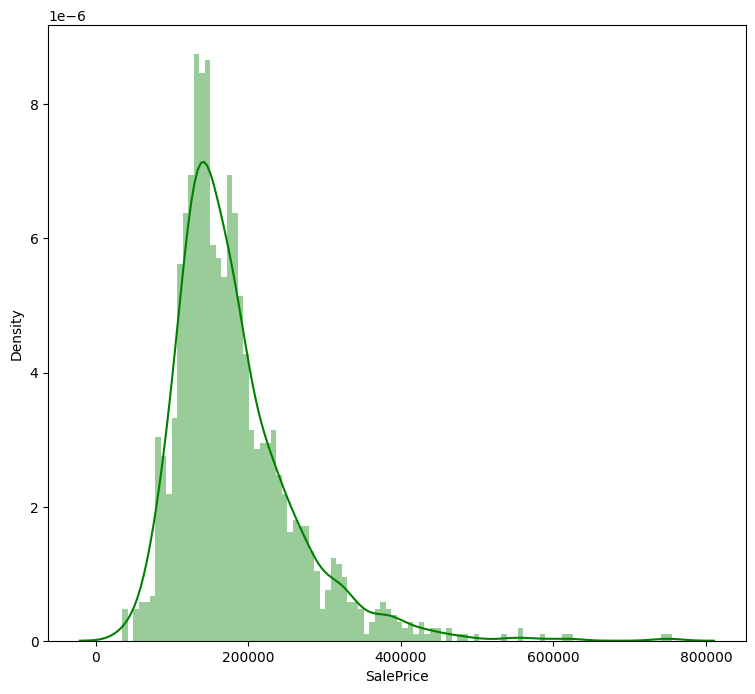

In [11]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [12]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

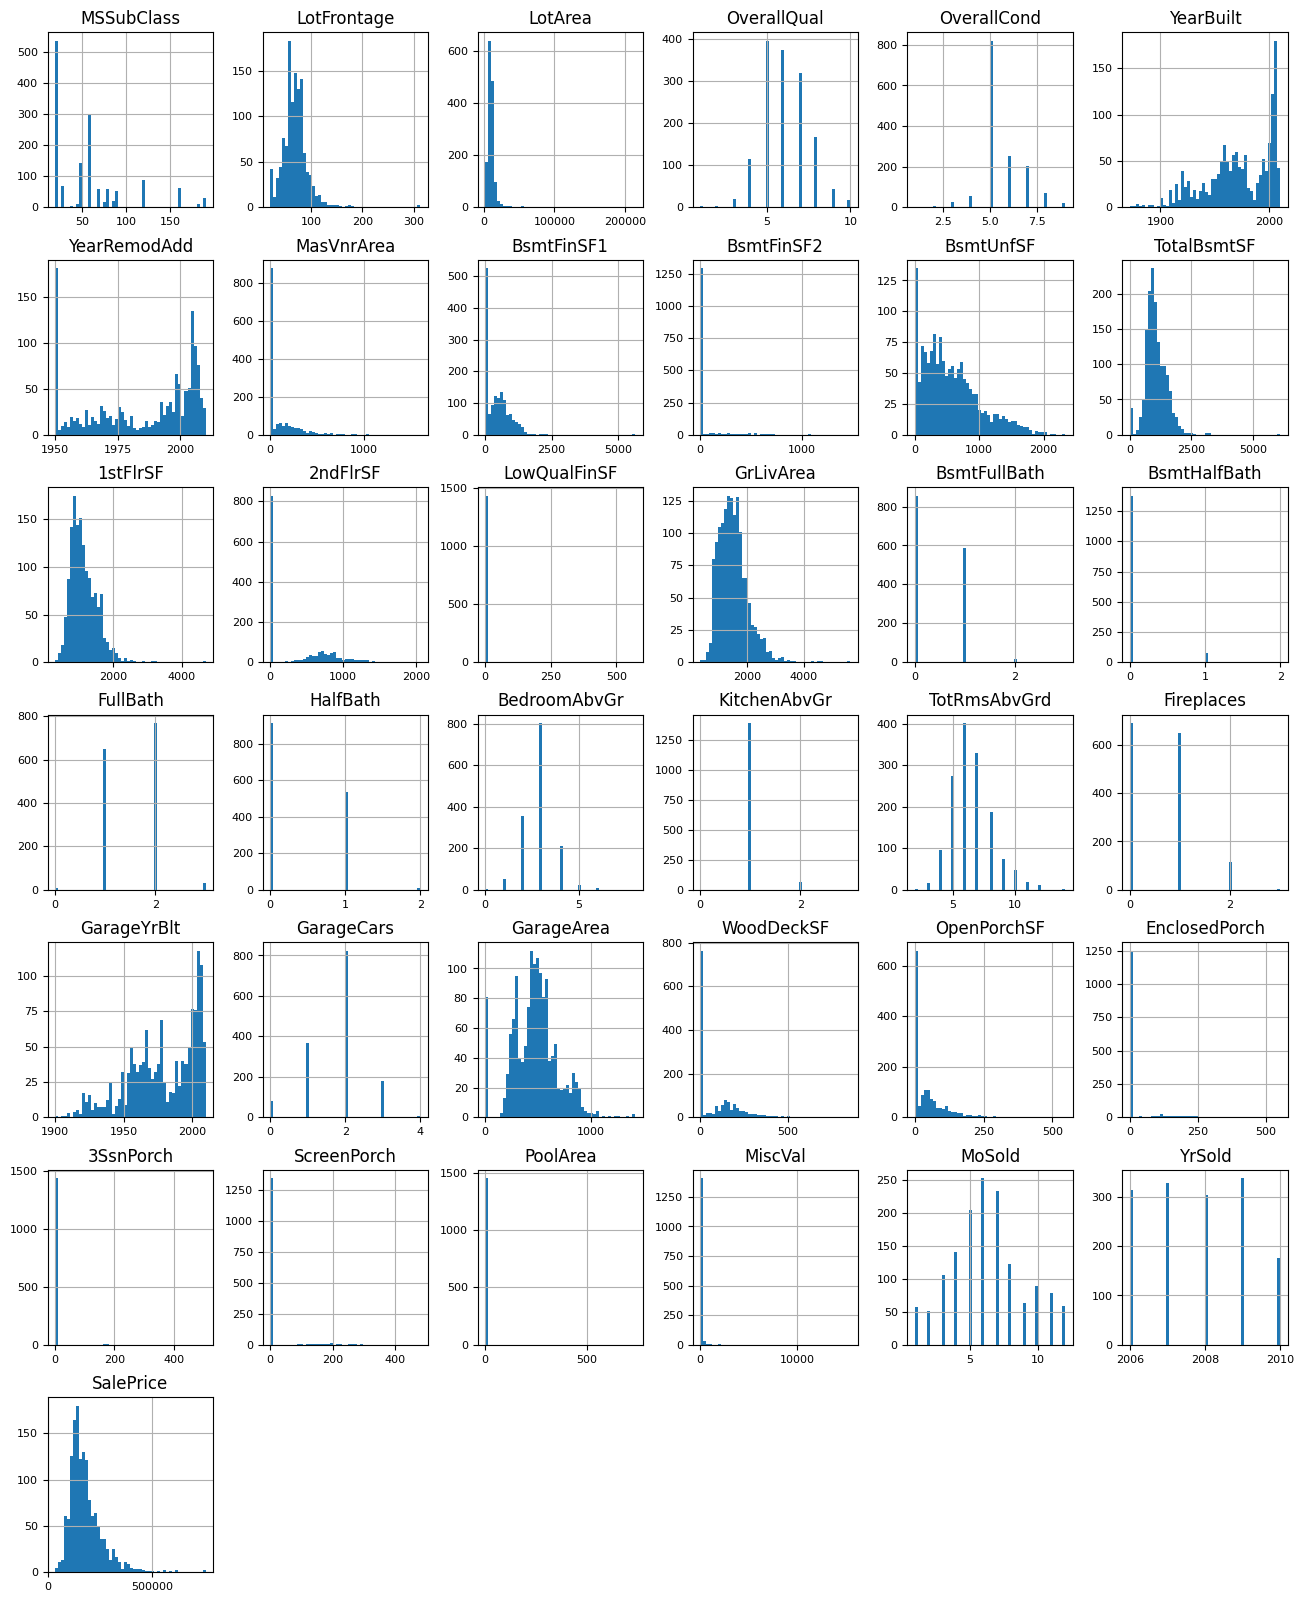

In [13]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [14]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

991 examples in training, 469 examples in testing.


In [15]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [16]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [17]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpzozmgv88 as temporary training directory


In [18]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:04.872398. Found 991 examples.
Training model...
Model trained in 0:00:04.090196
Compiling model...
Model compiled.


In [19]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

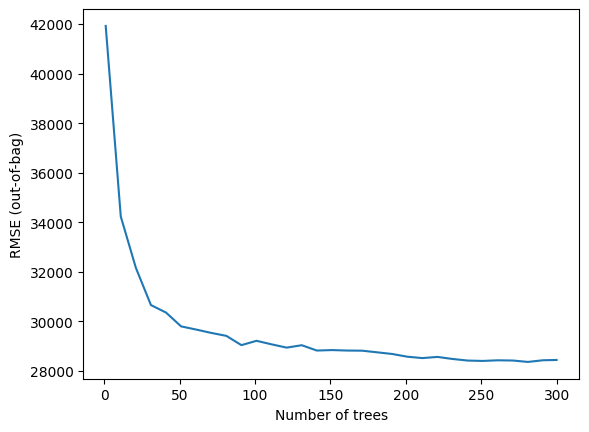

In [20]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [21]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=991, accuracy=None, loss=None, rmse=28442.15390230819, ndcg=None, aucs=None, auuc=None, qini=None)

In [22]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 703ms/step - loss: 0.0000e+00 - mse: 1006269504.0000
loss: 0.0000
mse: 1006269504.0000


In [23]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [24]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 105.0),
 ("ExterQual" (4; #22), 71.0),
 ("GarageCars" (1; #32), 50.0),
 ("Neighborhood" (4; #59), 27.0),
 ("YearBuilt" (1; #76), 14.0),
 ("KitchenQual" (4; #44), 8.0),
 ("BsmtQual" (4; #14), 7.0),
 ("GarageArea" (1; #31), 7.0),
 ("TotalBsmtSF" (1; #73), 5.0),
 ("GrLivArea" (1; #38), 3.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("1stFlrSF" (1; #0), 1.0)]

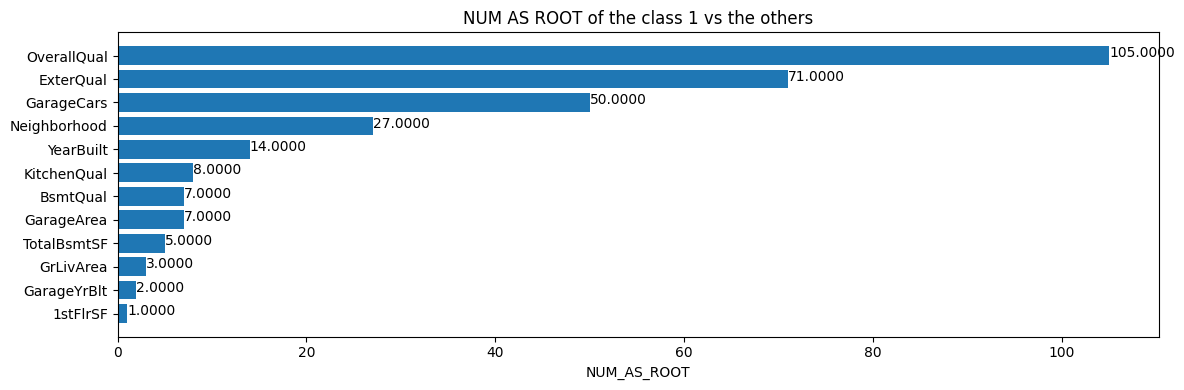

In [25]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [26]:
test_file_path = "test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()


2/2 [==============================] - 1s 26ms/step


Id      SalePrice
0  1461  127096.898438
1  1462  150532.703125
2  1463  175921.265625
3  1464  185897.140625
4  1465  201311.625000

In [27]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/house-prices-advanced-regression-techniques/sample_submission.csv'